In [1]:
%matplotlib inline

In [92]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim

import nltk
from collections import defaultdict
import re
import torch.utils.data as data
import sys
import os

from gensim import utils
from huffman_tree import HuffmanTree
from hierarchical_softmax import HierarchicalSoftmax
import hierarchical_softmax
import time
import copy

In [3]:
home_directory = os.path.expanduser('~')
nn_library_path = home_directory + '/Documents/HarveyMuddWork/Neural_Nets_Research/neural_nets_research/Neural Nets Library'
sys.path.append(nn_library_path)

In [4]:
import training

In [108]:
class CBOW(nn.Module):
    def __init__(self, vocab_size, hidden_size, huffman_tree = None):
        super(CBOW, self).__init__()
        
        self.embeddings = nn.Embedding(vocab_size, hidden_size, sparse=True)
        
        if huffman_tree is None:
            self.softmax_layer = nn.Linear(hidden_size, 1)
        else:
            self.softmax_layer = HierarchicalSoftmax(huffman_tree)
    
    def forward(self, context, id_list = None):
        if id_list is None:
            context_vector = torch.sum(self.embeddings(context), dim=1)
            probabilities = self.softmax_layer(context_vector)
        else:
            context_vector = torch.sum(self.embeddings(context), dim=1).squeeze()
            probabilities = self.softmax_layer(context_vector, id_list.squeeze())
        
        return probabilities
       
    def lookup(self, word, word_dictionary):
        word_id = word_dictionary[word]
        start_vec = Variable(torch.LongTensor([word_id]).unsqueeze(0)).cuda()
        
        return self.embeddings(start_vec).squueze()
    
    def backprop(self, id_list, lr):
        if not isinstance(self.softmax_layer, HierarchicalSoftmax):
            raise ValueError('You can only call backprop when using hierarchical softmax.')
        
        self.softmax_layer.backprop(id_list, lr)
        
        for p in self.embeddings.parameters():
            p.data = p.data + (-lr) * p.grad.data
            # zero gradients after we make the calculation
            p.grad.data.zero_()

In [109]:
def train_hierarchical_softmax_model(model, dset_loader, init_lr = 0.001, 
                                     num_epochs=20, print_every=200, plot_every=100):
    since = time.time()

    best_model = model
    best_loss = float('inf')
    model.train(True)

    running_loss = 0.0
    total_batch_number = 0
    all_losses = []
    
    lr_scheduler = hierarchical_softmax.lr_scheduler
    criterion = hierarchical_softmax.nll_cost

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        epoch_running_loss = 0.0
        current_batch = 0
        
        lr = lr_scheduler(epoch, init_lr=init_lr)
        
        # Iterate over data.
        for context, id_list in dset_loader:
            current_batch += 1
            total_batch_number += 1

            # wrap them in Variable
            context, id_list = Variable(context.cuda()), \
                             Variable(id_list.cuda())
            
            # forward
            outputs = model(context, id_list)
            loss = criterion(outputs)

            # backward
            loss.backward()
            model.backprop(id_list, lr)

            # statistics
            epoch_running_loss += loss.data[0]
            running_loss += loss.data[0]

            if total_batch_number % print_every == 0:
                curr_loss = epoch_running_loss / (current_batch * dset_loader.batch_size)
                time_elapsed = time.time() - since

                print('Epoch Number: {}, Batch Number: {}, Loss: {:.4f}'.format(
                    epoch, current_batch, curr_loss))
                print('Time so far is {:.0f}m {:.0f}s'.format(
                    time_elapsed // 60, time_elapsed % 60))

            if total_batch_number % plot_every == 0:
                all_losses.append(running_loss/ (total_batch_number * dset_loader.batch_size))


        # deep copy the model
        if epoch_running_loss < best_loss:
            best_loss = epoch_running_loss
            best_model = copy.deepcopy(model)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best loss: {:4f}'.format(best_loss))

    model.train(False)

    return best_model, all_losses

In [7]:
def filter_corpus(text, minimum_frequency=10):
    words = list(map(lambda word: word.lower(), filter(lambda word: re.match('[A-Za-z]', word) is not None, text)))
    frequencies = get_frequencies(words)
    
    return list(filter(lambda word: frequencies[word] >= minimum_frequency, words))

def make_word_dictionary(text):
    word_dictionary = {}
    word_index = 0
    
    for word in text:
        if word not in word_dictionary:
            word_dictionary[word] = word_index
            word_index += 1
    
    return word_dictionary

def make_huffman_tree(text, hidden_size):
    frequencies = list(get_frequencies(text).items())
    
    return HuffmanTree(frequencies, hidden_size)

In [8]:
class CBOWDataset(data.Dataset):
    def __init__(self, text, context_size, word_dictionary):
        self.word_dictionary = word_dictionary
        self.context_size = context_size
        self.word_indices = torch.LongTensor(list(map(lambda word: word_dictionary[word], text)))
        
    def __len__(self):
        return len(self.word_indices) - 2*self.context_size
    
    def __getitem__(self, index):
        prior_words = self.word_indices[index:index+context_size]
        later_words = self.word_indices[index+context_size+1:index+2*context_size+1]
        
        return torch.cat((prior_words, later_words)), self.word_indices[index+context_size]

In [9]:
penn_treebank_text = nltk.corpus.treebank.words()
training_corpus = filter_corpus(penn_treebank_text)
word_dictionary = make_word_dictionary(training_corpus)
context_size = 4
vocab_size = len(word_dictionary)

dataset = CBOWDataset(training_corpus, context_size, word_dictionary)

In [10]:
id_to_word = []
id_to_word_dict = {}

for word, id_value in word_dictionary.items():
    id_to_word_dict[id_value] = word

for i in range(len(id_to_word_dict)):
    id_to_word.append(id_to_word_dict[i])

In [11]:
hidden_size = 200
huffman_tree = make_huffman_tree(map(lambda word: word_dictionary[word], training_corpus), hidden_size)

In [106]:
word2vec_model = CBOW(vocab_size, hidden_size, huffman_tree).cuda()
data_loader = data.DataLoader(dataset, batch_size = 1, shuffle = True, num_workers = 1, pin_memory = True)

In [107]:
word2vec_model, losses = train_CBOW_model(word2vec_model, data_loader, num_epochs=1)

Epoch 0/0
----------
Epoch Number: 0, Batch Number: 200, Loss: 8.9244
Time so far is 0m 1s
Epoch Number: 0, Batch Number: 400, Loss: 7.3373
Time so far is 0m 2s
Epoch Number: 0, Batch Number: 600, Loss: 6.1631
Time so far is 0m 3s
Epoch Number: 0, Batch Number: 800, Loss: 5.4398
Time so far is 0m 4s
Epoch Number: 0, Batch Number: 1000, Loss: 5.0386
Time so far is 0m 5s
Epoch Number: 0, Batch Number: 1200, Loss: 4.6774
Time so far is 0m 6s
Epoch Number: 0, Batch Number: 1400, Loss: 4.3757
Time so far is 0m 7s
Epoch Number: 0, Batch Number: 1600, Loss: 4.1464
Time so far is 0m 8s
Epoch Number: 0, Batch Number: 1800, Loss: 3.9376
Time so far is 0m 10s
Epoch Number: 0, Batch Number: 2000, Loss: 3.7115
Time so far is 0m 11s
Epoch Number: 0, Batch Number: 2200, Loss: 3.5521
Time so far is 0m 12s
Epoch Number: 0, Batch Number: 2400, Loss: 3.4031
Time so far is 0m 13s
Epoch Number: 0, Batch Number: 2600, Loss: 3.2955
Time so far is 0m 14s
Epoch Number: 0, Batch Number: 2800, Loss: 3.1834
Time 

Epoch Number: 0, Batch Number: 22800, Loss: 1.0522
Time so far is 1m 59s
Epoch Number: 0, Batch Number: 23000, Loss: 1.0475
Time so far is 1m 60s
Epoch Number: 0, Batch Number: 23200, Loss: 1.0412
Time so far is 2m 1s
Epoch Number: 0, Batch Number: 23400, Loss: 1.0361
Time so far is 2m 2s
Epoch Number: 0, Batch Number: 23600, Loss: 1.0326
Time so far is 2m 3s
Epoch Number: 0, Batch Number: 23800, Loss: 1.0273
Time so far is 2m 4s
Epoch Number: 0, Batch Number: 24000, Loss: 1.0219
Time so far is 2m 5s
Epoch Number: 0, Batch Number: 24200, Loss: 1.0156
Time so far is 2m 6s
Epoch Number: 0, Batch Number: 24400, Loss: 1.0105
Time so far is 2m 7s
Epoch Number: 0, Batch Number: 24600, Loss: 1.0059
Time so far is 2m 8s
Epoch Number: 0, Batch Number: 24800, Loss: 1.0010
Time so far is 2m 9s
Epoch Number: 0, Batch Number: 25000, Loss: 0.9955
Time so far is 2m 10s
Epoch Number: 0, Batch Number: 25200, Loss: 0.9903
Time so far is 2m 11s
Epoch Number: 0, Batch Number: 25400, Loss: 0.9849
Time so f

Epoch Number: 0, Batch Number: 45400, Loss: 0.6779
Time so far is 3m 56s
Epoch Number: 0, Batch Number: 45600, Loss: 0.6760
Time so far is 3m 57s
Epoch Number: 0, Batch Number: 45800, Loss: 0.6741
Time so far is 3m 58s
Epoch Number: 0, Batch Number: 46000, Loss: 0.6718
Time so far is 3m 59s
Epoch Number: 0, Batch Number: 46200, Loss: 0.6697
Time so far is 3m 60s
Epoch Number: 0, Batch Number: 46400, Loss: 0.6684
Time so far is 4m 1s
Epoch Number: 0, Batch Number: 46600, Loss: 0.6668
Time so far is 4m 2s
Epoch Number: 0, Batch Number: 46800, Loss: 0.6648
Time so far is 4m 3s
Epoch Number: 0, Batch Number: 47000, Loss: 0.6635
Time so far is 4m 4s
Epoch Number: 0, Batch Number: 47200, Loss: 0.6615
Time so far is 4m 5s
Epoch Number: 0, Batch Number: 47400, Loss: 0.6596
Time so far is 4m 6s
Epoch Number: 0, Batch Number: 47600, Loss: 0.6579
Time so far is 4m 7s
Epoch Number: 0, Batch Number: 47800, Loss: 0.6560
Time so far is 4m 8s
Epoch Number: 0, Batch Number: 48000, Loss: 0.6543
Time so 

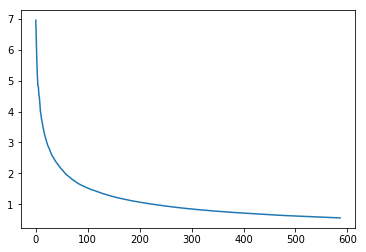

In [98]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(losses)

In [ ]:
def most_similar(model, positive1, negative, positive2):
    """
    Find the top-N most similar words. Positive words contribute positively towards the
    similarity, negative words negatively.
    """
    words_matrix = model.embeddings.weight
    guess_vector = positive1 - negative + positive2
    distances = F.pairwise_distance(guess_vector.expand_as(word_matrix), word_matrix)
    _, word_i = distances.data.max(1)
    
    return word_i

def log_accuracy(section):
    correct, incorrect = section['correct'], section['incorrect']
    if correct + incorrect > 0:
        print("%s: %.1f%% (%i/%i)" %
            (section['section'], 100.0 * correct / (correct + incorrect),
            correct, correct + incorrect))

def accuracy(model, questions, ok_words, word_dictionary):
    """
    Compute accuracy of the word embeddings.
    `questions` is a filename where lines are 4-tuples of words, split into
    sections by ": SECTION NAME" lines.
    See https://code.google.com/p/word2vec/source/browse/trunk/questions-words.txt for an example.
    The accuracy is reported (=printed to log and returned as a list) for each
    section separately, plus there's one aggregate summary at the end.
    Only evaluate on words in `word2id` (such as 30k most common words), ignoring
    any test examples where any of the four words falls outside `word2id`.
    This method corresponds to the `compute-accuracy` script of the original C word2vec.
    """

    sections, section = [], None
    for line_no, line in enumerate(utils.smart_open(questions)):
        line = utils.to_unicode(line)
        if line.startswith(': '):
            # a new section starts => store the old section
            if section:
                sections.append(section)
                log_accuracy(section)
            section = {'section': line.lstrip(': ').strip(), 'correct': 0, 'incorrect': 0}
        else:
            if not section:
                raise ValueError("missing section header before line #%i in %s" % (line_no, questions))
            try:
                a, b, c, expected = [word.lower() for word in line.split()] 
            except:
                print("skipping invalid line #%i in %s" % (line_no, questions))
            if a not in ok_words or b not in ok_words or c not in ok_words or expected not in ok_words:
                print("skipping line #%i with OOV words: %s" % (line_no, line.strip()))
                continue

            ignore = set(word_dictionary[v] for v in [a, b, c])  # indexes of words to ignore
            predicted = None

            # find the most likely prediction, ignoring OOV words and input words
            sims = most_similar(model, a, b, c)
            for index in numpy.argsort(sims)[::-1]:
                if model.id2word[index] in ok_words and index not in ignore:
                    predicted = model.id2word[index]
                    if predicted != expected:
                        print("%s: expected %s, predicted %s" % (line.strip(), expected, predicted))
                    break

            section['correct' if predicted == expected else 'incorrect'] += 1

    if section:
        # store the last section, too
        sections.append(section)
        log_accuracy(section)

    total = {'section': 'total', 'correct': sum(s['correct'] for s in sections), 'incorrect': sum(s['incorrect'] for s in sections)}
    log_accuracy(total)
    sections.append(total)
    return sections

In [ ]:
word2vec_model.module.lookup('man', word_dictionary)